In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import the libraries
import torchvision
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import shutil 
from customDatasetClass import pcbDataset
from get_image_prediction import getPrediction, getLabel
import transforms as tf
import utils
from engine import train_one_epoch, evaluate
import torch

In [4]:
# create folders for Images(all), Training, Test and Validation images in pwd
!mkdir Images
!mkdir Training
!mkdir Testing
!mkdir Validation

In [5]:
# copy the images from drive into the above created directory
!cp -r /content/drive/MyDrive/Research/PCB_multierror_4combined /content/Images/

In [6]:
# stores all the images from the directory onto a list
images_dir = "/content/Images/PCB_multierror_4combined"
all_images = os.listdir(images_dir)
print("The dataset consists of {} images".format(len(all_images)))

The dataset consists of 12000 images


In [7]:
# listing the paths for train, test and validation images
train_dir = "/content/Training/"
test_dir = "/content/Testing/"
validation_dir = "/content/Validation/"

In [8]:
# divide the total images into respective folders - train, test and validation
train_validation, test = train_test_split(all_images, test_size = 0.15, shuffle=True)

# splitting the train_val_set into train and val sets
train, validation = train_test_split(train_validation, test_size=0.15, shuffle=True)

In [9]:
# putting the data into their seperate folders - train, validation, & test
for i in train:
  image_name = i.split('/')[-1]
  shutil.copy(images_dir+"/"+image_name, train_dir+image_name)

for i in validation:
  image_name = i.split('/')[-1]
  shutil.copy(images_dir+"/"+image_name, validation_dir+image_name)

for i in test:
  image_name = i.split('/')[-1]
  shutil.copy(images_dir+"/"+image_name, test_dir+image_name)

In [10]:
print("The size of training directory is {}".format(len(os.listdir(train_dir))))
print("The size of validation directory is {}".format(len(os.listdir(validation_dir))))
print("The size of test directory is {}".format(len(os.listdir(test_dir))))

The size of training directory is 8670
The size of validation directory is 1530
The size of test directory is 1800


In [11]:
# convert the images into tensors and apply transforms on train images
def perform_transforms(train_images):
    transformed_Images = []
    transformed_Images.append(tf.ToTensor())
    if train_images == True:
        transformed_Images.append(tf.RandomHorizontalFlip(0.5))
        print("Applied tranformations")
    return tf.Compose(transformed_Images)

In [12]:
# using the python custom dataset script to create following datasets
labels_dir = "/content/Combined_4_files.csv"
trainData = pcbDataset(labels_dir, train_dir, transforms=perform_transforms(train_images = True))
testData = pcbDataset(labels_dir, test_dir, transforms=perform_transforms(train_images=False))
valData= pcbDataset(labels_dir, validation_dir, transforms=perform_transforms(train_images=False)) 

# creating raw test dataset (without transforms) for generating ground truth and for making predictions 
test_data_raw = pcbDataset(labels_dir, test_dir)
#raw_val_data = pcbDataset(labels_dir, validation_dir)

Applied tranformations


In [13]:
testData[50]

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 {'labels': tensor([1, 3, 3, 4, 6, 5, 5]),
  'boxes': tensor([[412., 503., 456., 537.],
          [216.,  48., 245.,  86.],
          [319., 281., 372., 317.],
          [383., 331., 418., 368.],
          [386., 307., 437., 336.],
          [453., 147., 506., 186.],
          [255., 200., 299., 251.]]),
  'area': tensor([1496., 1102., 1908., 1295., 1479., 2067., 2244.]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0]),
  'image_id': tensor([50])})

In [14]:
test_data_raw[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=L size=640x640 at 0x7F00503C1C10>,
 {'labels': tensor([1, 3, 4, 5, 6, 3]),
  'boxes': tensor([[ 69., 458., 100., 500.],
          [265., 119., 298., 148.],
          [303., 255., 345., 287.],
          [364., 420., 397., 458.],
          [396., 309., 433., 334.],
          [150., 537., 181., 567.]]),
  'area': tensor([1302.,  957., 1344., 1254.,  925.,  930.]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0]),
  'image_id': tensor([0])})

In [15]:
# defining the number of classes and loading the model with pretrained backbone
no_of_classes = len(trainData.label_dictionary) + 1

#SSD_model = torchvision.models.detection.ssd300_vgg16(pretrained = False, progress=True, num_classes=no_of_classes, pretrained_backbone=True, trainable_backbone_layers=2)

#Loading the previously trained model
SSD_model = torch.load('/content/drive/MyDrive/Research/trained_model.pkl')

In [16]:
# setting the device to gpu when available else set to cpu
device_type = ""
if torch.cuda.is_available():
  device_type = torch.device('cuda')
else:
  device_type = torch.device('cpu')
device_type

device(type='cuda')

In [17]:
SSD_model.to(device_type)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [30]:
#enabling the model on the above chosen device type (GPU)
SSD_model.to(device_type)  

batch_size = 32
epochs = 30  

# designing a custom lr scheduler and optimizer
parameters = [param for param in SSD_model.parameters() if param.requires_grad]
SGD_optimizer = torch.optim.SGD(parameters, weight_decay=0.0005, lr=0.0003, momentum=0.9) 
learning_rate_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(SGD_optimizer, T_mult=2, T_0=1)

In [31]:
#define 3 data loaders - train, test and validation to feed the respective images to the model
training_data_loader = torch.utils.data.DataLoader(trainData, collate_fn=utils.collate_fn, batch_size=batch_size,  shuffle=True)
validation_data_loader = torch.utils.data.DataLoader(valData, collate_fn=utils.collate_fn, batch_size=batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(testData, collate_fn=utils.collate_fn, batch_size=batch_size, shuffle=False)

In [32]:
# Training the model 
for epoch in range(epochs):
    train_one_epoch(SSD_model, SGD_optimizer, training_data_loader, device_type, epoch, print_freq=71)
# modify the lr for each step
    learning_rate_scheduler.step()
# evaluate the model on the validation data
    evaluations = evaluate(SSD_model, validation_data_loader, device=device_type) 
# save the trained model for future predictions   
    torch.save(SSD_model,'/content/drive/MyDrive/Research/trained_model.pkl')
    print("****************************************************************")
print("Finished Training for {} epochs". format(epochs))

Epoch: [0]  [  0/271]  eta: 0:02:41  lr: 0.000001  loss: 74.5348 (74.5348)  bbox_regression: 4.3228 (4.3228)  classification: 70.2120 (70.2120)  time: 0.5973  data: 0.4450  max mem: 2808
Epoch: [0]  [ 71/271]  eta: 0:01:46  lr: 0.000080  loss: 10.1622 (17.4501)  bbox_regression: 2.2751 (2.8433)  classification: 7.8574 (14.6069)  time: 0.5456  data: 0.3994  max mem: 2987
Epoch: [0]  [142/271]  eta: 0:01:08  lr: 0.000159  loss: 9.6663 (13.6606)  bbox_regression: 2.0915 (2.4974)  classification: 7.5958 (11.1632)  time: 0.5280  data: 0.3838  max mem: 2990
Epoch: [0]  [213/271]  eta: 0:00:30  lr: 0.000238  loss: 8.7676 (12.1744)  bbox_regression: 1.5729 (2.2648)  classification: 7.2350 (9.9095)  time: 0.5159  data: 0.3726  max mem: 2990
Epoch: [0]  [270/271]  eta: 0:00:00  lr: 0.000300  loss: 8.1530 (11.3841)  bbox_regression: 1.2794 (2.0812)  classification: 6.8964 (9.3029)  time: 0.5215  data: 0.3788  max mem: 2993
Epoch: [0] Total time: 0:02:22 (0.5250 s / it)
creating index...
index cre

In [20]:
# loading the previously saved SSD model
SSD_model_trained = torch.load('/content/drive/MyDrive/Research/trained_model.pkl')

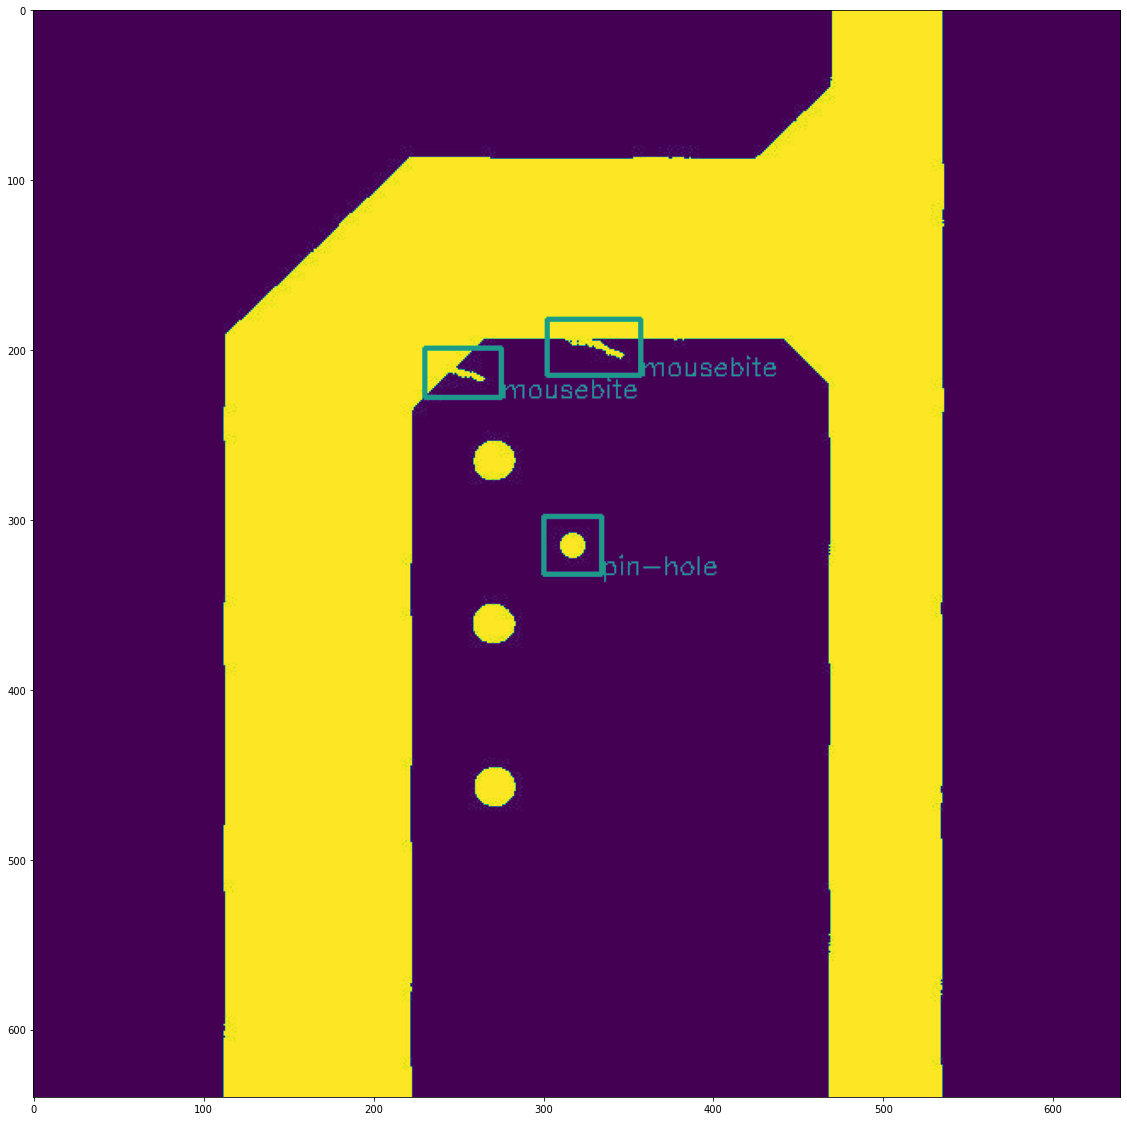

In [22]:
# Generating the ground truth for sample image to compare to prediction below
groundtruth_index = 749

sample_image = np.array(test_data_raw[groundtruth_index][0])
ground_bbox = test_data_raw[groundtruth_index][1]['boxes']
ground_labels = test_data_raw[groundtruth_index][1]['labels']

g_box_len = len(ground_bbox)

for i in range(g_box_len):

  num_label = ground_labels[i]
  text_label = getLabel(num_label)
  
  x_min = round(int(ground_bbox[i][0]))
  y_min = round(int(ground_bbox[i][1]))
  x_max = round(int(ground_bbox[i][2]))
  y_max = round(int(ground_bbox[i][3]))

  cv2.rectangle(sample_image, (x_min, y_min), (x_max, y_max), (139, 0, 0), thickness=2)
  cv2.putText(sample_image, text_label, (x_max, y_max), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (139, 0, 0), thickness=1)

plt.figure(figsize=(20,20))
plt.imshow(sample_image)

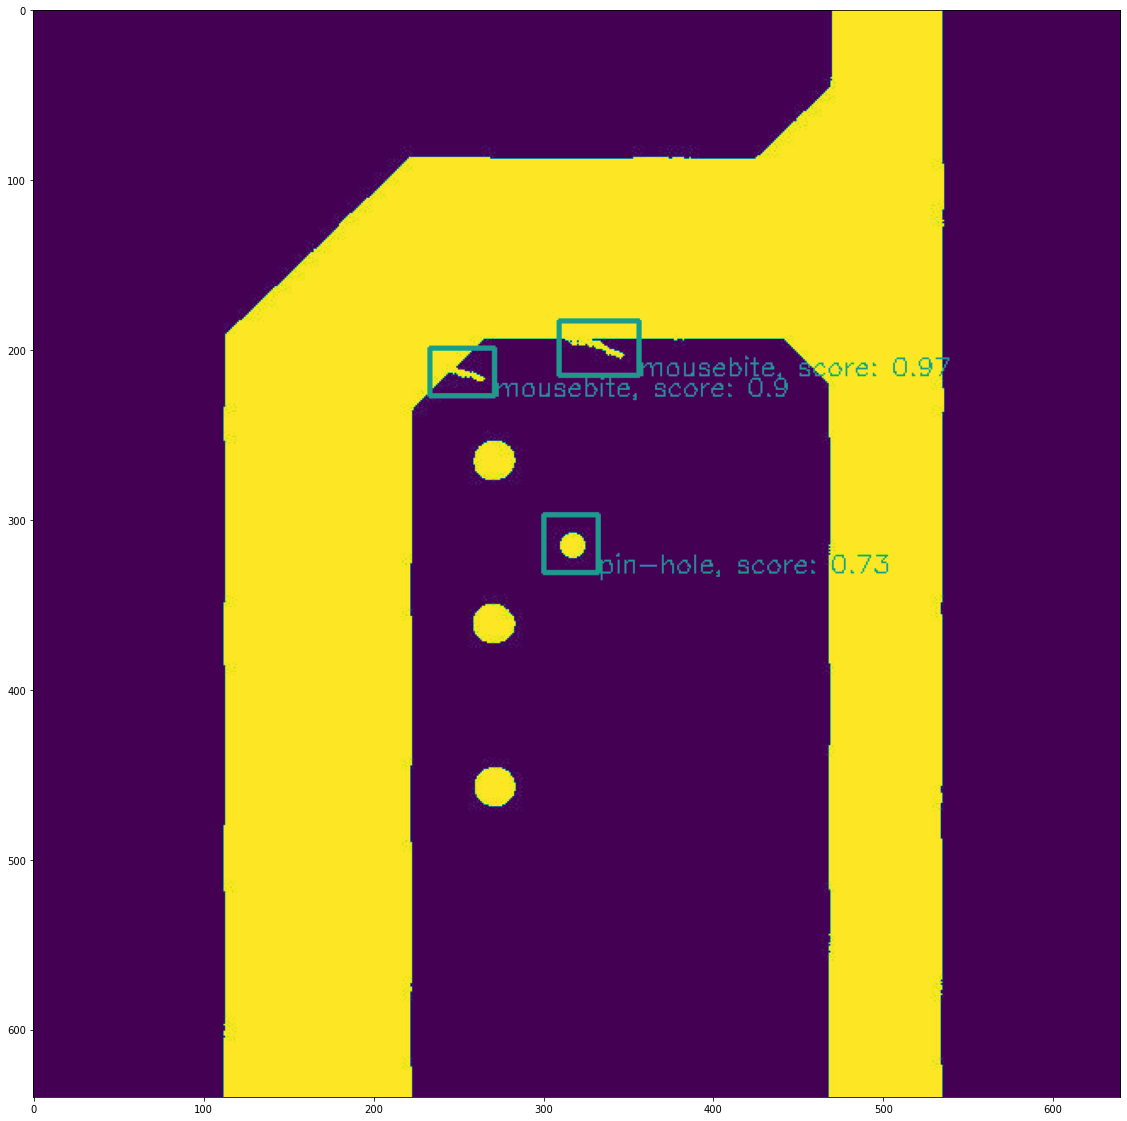

In [23]:
# making predictions
prediction_index = 749
rawImage = np.array(test_data_raw[prediction_index][0])
imageTensor = testData[prediction_index][0]
final_prediction = getPrediction(SSD_model_trained, imageTensor, rawImage, device_type)